# NN

In [2]:
from __future__ import division
from __future__ import print_function

import matplotlib

import pandas

import matplotlib.pyplot as plt
import numpy as np

import timeit #more accurate than time

%matplotlib inline

from scipy import stats
from scipy.optimize import curve_fit
from scipy import exp, sqrt, pi, power
from scipy.special import erf
import sys
sys.path.append('../ML/modules/')
from helper import *
from DataInfo import *


import seaborn as sns
sns.set_style("white")

## Skim size, Acceptance, xSec and luminosity

## import data from root files

In [4]:
loc = '../data_n/'

energies = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]

signalData = []
backgroundData = []

for energy in energies:
    signalData.append(pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + 
                                      str(energy) + "_narrow_13TeV-madgraph.csv"))

# same as 2 but only the first half of the events
#backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_1.csv"))
backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv"))
backgroundData.append(pandas.read_csv(loc + "WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv"))


# drop columns without header
for signal_data in signalData:
    signal_data.drop([x for x in signal_data.columns if 'Unnamed' in x], axis=1, inplace=True)

for background_data in backgroundData:
    background_data.drop([x for x in background_data.columns if 'Unnamed' in x], axis=1, inplace=True)

allSignalData = signalData[0]
for signal_data in signalData[1:]:
    allSignalData = allSignalData.append(signal_data, ignore_index=True)

allBackgroundData = backgroundData[0]
for background_data in backgroundData[1:]:
    allBackgroundData = allBackgroundData.append(background_data, ignore_index=True)

for i in range(len(energies)):
    print("{} events for Higgs with {} GeV".format(len(signalData[i]), energies[i]))
print("{} TT_Tune events".format(len(backgroundData[0])))
print("{} WJetsToLNu_Tune events".format(len(backgroundData[1])), end='\n\n')
print("{} events of Higgs".format(len(allSignalData)))
print("{} background events".format(len(allBackgroundData)))

403 events for Higgs with 260 GeV
394 events for Higgs with 270 GeV
390 events for Higgs with 280 GeV
372 events for Higgs with 300 GeV
479 events for Higgs with 320 GeV
655 events for Higgs with 400 GeV
1619 events for Higgs with 500 GeV
1858 events for Higgs with 550 GeV
2008 events for Higgs with 600 GeV
2239 events for Higgs with 700 GeV
166157 TT_Tune events
1896 WJetsToLNu_Tune events

10417 events of Higgs
168053 background events


### Calculate significância

In [5]:
def SignalSignificanceSelector(SignalSignificance):
    temp = sorted(SignalSignificance)[0:min(len(SignalSignificance), 3)]
    return sum(temp)/len(temp)

def calculateFOM(Signals, Backgounds, signalIdx, backgroundIdx, minimum=False):
    s_signal, s_background = [], 0
    for i, signal in enumerate(Signals):
        s_signal.append(len(signal) * signalXSec[signalIdx[i]] / signalFullSize[signalIdx[i]] * luminosity)
    
    for i, background in enumerate(Backgounds):
        s_background += len(background) * backgroundXSec[backgroundIdx[i]] / backgroundFullSize[backgroundIdx[i]] * luminosity
    
    if s_background != 0:
        return SignalSignificanceSelector(s_signal) / sqrt(s_background)
    else:
        return -1

## Select the sets of data to analise

In [13]:
# Indexes to merge and analise
signalIdx = [energies.index(260)] # range(len(signalData)) 
backgroundIdx = range(len(backgroundData))
    
# Create a new variable with the data to analise
signalAnal = [signalData[i] for i in signalIdx]
backgroundAnal = [backgroundData[i] for i in backgroundIdx]

# Data to analise all merged
allSignalAnal = signalAnal[0]
for i in range(1, len(signalAnal)):
    allSignalAnal = allSignalAnal.append(signalAnal[i], ignore_index=True)
    
allBackgroundAnal = backgroundAnal[0]
for i in range(1, len(backgroundAnal)):
    allBackgroundAnal = allBackgroundAnal.append(backgroundAnal[i], ignore_index=True)

# Variables to create the cuts

signalSelector = [pandas.Series(np.ones(len(signal_anal), dtype=bool)) for signal_anal in signalAnal]
backgroundSelector = [pandas.Series(np.ones(len(background_anal), dtype=bool)) for background_anal in backgroundAnal]

#
# Add conditions here:
#

for selector, analData in [(signalSelector, signalAnal), (backgroundSelector, backgroundAnal)]:
    for i in range(len(selector)):
        selector[i] = selector[i] & (analData[i]['b_0_csv'] > 0.8)
        selector[i] = selector[i] & (analData[i]['b_1_csv'] > 0.8)
        #selector[i] = selector[i] & ((analData[i]['h_bb_mass'] < 160) & (analData[i]['h_bb_mass'] > 90))
        #selector[i] = selector[i] & ((analData[i]['h_tt_svFit_mass'] < 160) & (analData[i]['h_tt_svFit_mass'] > 80))
        selector[i] = selector[i] & (((analData[i]['h_bb_mass']-116)/35)**2 + ((analData[i]['h_tt_svFit_mass']-111)/45)**2 < 1)
        #selector[i] = selector[i] & (analData[i]['b_0_pT'] < 130)
        #selector[i] = selector[i] & (analData[i]['t_1_pT'] < 60) #ok cut for all together
        #selector[i] = selector[i] & (analData[i]['t_0_pT'] > 30) #cuts a lot of signal
        #selector[i] = selector[i] & (analData[i]['h_tt_pT'] < 160)
        #selector[i] = selector[i] & (analData[i]['h_bb_pT'] < 60)
        #selector[i] = selector[i] & (analData[i]['mPT_pT'] < 100)
        #selector[i] = selector[i] & (analData[i]['diH_pT'] < 160) #bad cut
        #selector[i] = selector[i] & (analData[i]['hT'] < 250)
        #selector[i] = selector[i] & (analData[i]['sT'] < 250)
        #selector[i] = selector[i] & (analData[i]['mT'] < 42) # ok cut with all together
        pass
    
# Data after cuts
cutSignalAnal, cutBackgroundAnal = [], []

for i in range(len(signalAnal)):
    cutSignalAnal.append(signalAnal[i][signalSelector[i]])
    
for i in range(len(backgroundAnal)):
    cutBackgroundAnal.append(backgroundAnal[i][backgroundSelector[i]])

# Data after cuts merged
allCutSignalAnal = cutSignalAnal[0]
for i in range(1, len(signalAnal)):
    allCutSignalAnal = allCutSignalAnal.append(cutSignalAnal[i], ignore_index=True)
    
allCutBackgroundAnal = cutBackgroundAnal[0]
for i in range(1, len(backgroundAnal)):
    allCutBackgroundAnal = allCutBackgroundAnal.append(cutBackgroundAnal[i], ignore_index=True)
    
print(calculateFOM(cutSignalAnal, cutBackgroundAnal, signalIdx, backgroundIdx))
    
print("new:      {:6} events for signal and {:6} events for background".format(len(allCutSignalAnal), len(allCutBackgroundAnal)))
print("original: {:6} events for signal and {:6} events for background".format(len(allSignalAnal), len(allBackgroundAnal)))

print("FOM is: {:.6}".format(calculateFOM(cutSignalAnal, cutBackgroundAnal, signalIdx, backgroundIdx)))
print("FOM with no cuts is: {:.6}".format(calculateFOM(signalAnal, backgroundAnal, signalIdx, backgroundIdx)))

# for excel
print(len(allCutSignalAnal), len(allCutBackgroundAnal), str(calculateFOM(cutSignalAnal, cutBackgroundAnal, signalIdx, backgroundIdx)).replace('.',','), sep=';')

0.0752360490628
new:         102 events for signal and   8381 events for background
original:    403 events for signal and 168053 events for background
FOM is: 0.075236
FOM with no cuts is: 0.0407567
102;8381;0,0752360490628


### Single variable analysis

In [7]:
def taylorExpand(x, x0, a, *coefs):
    return a + sum([coef * pow(x-x0, i+2) for i, coef in enumerate(coefs)])

def AcceptanceAfterCuts(varToAnalise, limit, fit=False, upperLimit=True, p0=None, bounds=None):
    x = np.linspace(limit[0], limit[1], 100)
    y = []
    for j in x:
        newSignalSelector = [pandas.Series(np.ones(len(signal_anal), dtype=bool)) for signal_anal in signalAnal]
        newBackgroundSelector = [pandas.Series(np.ones(len(background_anal), dtype=bool)) for background_anal in backgroundAnal]
        for newSelector, selector, analData in [(newSignalSelector, signalSelector, signalAnal), (newBackgroundSelector, backgroundSelector, backgroundAnal)]:
            for i in range(len(selector)):
                if upperLimit:
                    newSelector[i] = selector[i] & (analData[i][varToAnalise] < j)
                else:
                    newSelector[i] = selector[i] & (analData[i][varToAnalise] > j)

        newCutSignalAnal, newCutBackgroundAnal = [], []

        for i in range(len(signalAnal)):
            newCutSignalAnal.append(signalAnal[i][newSignalSelector[i]])

        for i in range(len(backgroundAnal)):
            newCutBackgroundAnal.append(backgroundAnal[i][newBackgroundSelector[i]])
        y.append(calculateFOM(newCutSignalAnal, newCutBackgroundAnal, signalIdx, backgroundIdx))

    plt.plot(x,y)
    
    if fit:
        if not p0:
            p0 = [(limit[0]+limit[1])/2, max(y), -0.001, -0.001]
        if not bounds:
            bounds = [[limit[0], max(y)/1.5, -50, -50],[limit[1], max(y)*1.5, 0, 50]]

        popt,pcov = curve_fit(taylorExpand, x, y, p0=p0, bounds=bounds)

        print(popt)

        plt.plot(x, taylorExpand(x, *popt))

[  3.99079142e+01   8.11893775e-02  -1.87671798e-05   2.23524841e-07]


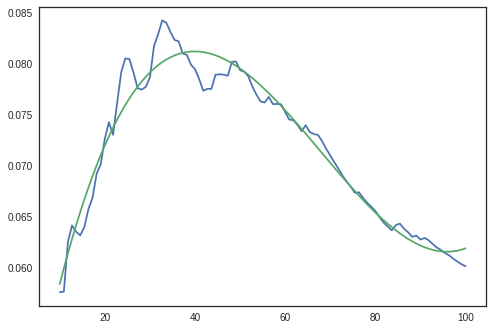

In [8]:
AcceptanceAfterCuts('mT', limit=[10,100], upperLimit=True, fit=True)

### calculate weights to normalise the data based on XSec and acceptance

In [15]:
# make so that Signal and Background have the same area in the histogram
normalizeSignalBackground = False

# combine diferent signals in histogram
combineSignal = False

#normalize data for ploting

weightsSignal = []
for i, idx in enumerate(signalIdx):
    weightsSignal.append(1/signalFullSize[idx] * signalXSec[idx] * luminosity)

weightsBackground = []
for i, idx in enumerate(backgroundIdx):
    weightsBackground.append(1/backgroundFullSize[idx]*backgroundXSec[idx] * luminosity)

# weights for data without cuts

if combineSignal:
    weightSignal = np.empty(0)
    for i in range(len(signalAnal)):
        weightSignal = np.append(weightSignal, np.full(len(signalAnal[i]), weightsSignal[i]))
    weightSignal = [weightSignal]
else:
    weightSignal = [np.full(len(signalAnal[i]), weightsSignal[i]) for i in range(len(signalAnal))]
        
weightBackground = np.empty(0)
for i in range(len(backgroundAnal)):
    weightBackground = np.append(weightBackground, np.full(len(backgroundAnal[i]), weightsBackground[i]))
    
# weights for data with cuts

if combineSignal:
    weightCutSignal = np.empty(0)
    for i in range(len(signalAnal)):
        weightCutSignal = np.append(weightCutSignal, np.full(len(cutSignalAnal[i]), weightsSignal[i]))
    weightCutSignal = [weightCutSignal]
else:
    weightCutSignal = [np.full(len(cutSignalAnal[i]), weightsSignal[i]) for i in range(len(cutSignalAnal))]
        
weightCutBackground = np.empty(0)
for i in range(len(backgroundAnal)):
    weightCutBackground = np.append(weightCutBackground, np.full(len(cutBackgroundAnal[i]), weightsBackground[i]))
    
# signal/background ratio (used to normalize histogram if wanted)
if normalizeSignalBackground:
    weightRatio = [np.sum(x) for x in weightSignal]/np.sum(weightBackground)
    weightCutRatio = [np.sum(x) for x in weightCutSignal]/np.sum(weightCutBackground)
else:
    weightRatio = [1 for x in weightSignal]
    weightCutRatio = [1 for x in weightCutSignal]

### Plot the background and data for the data with and without cuts

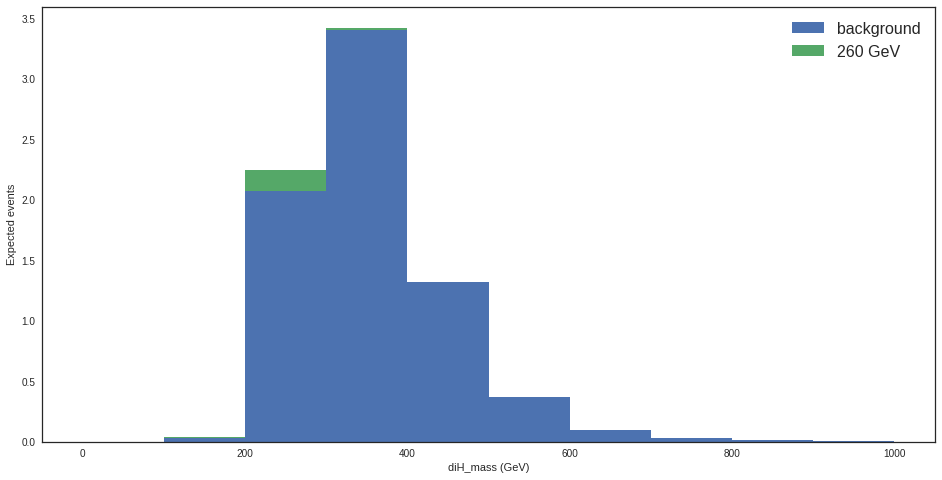

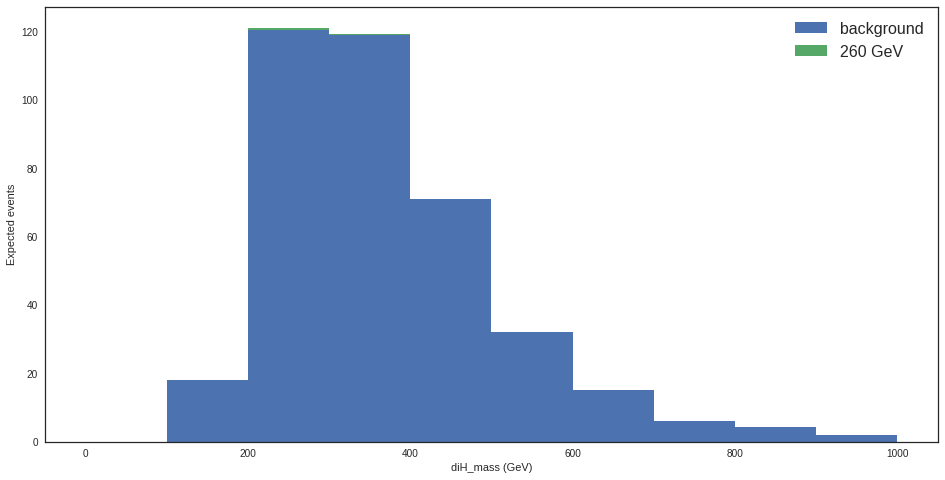

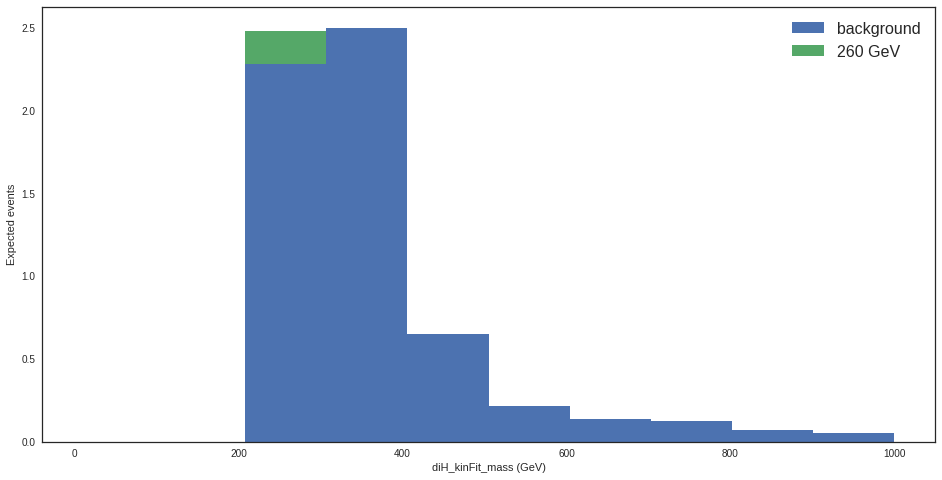

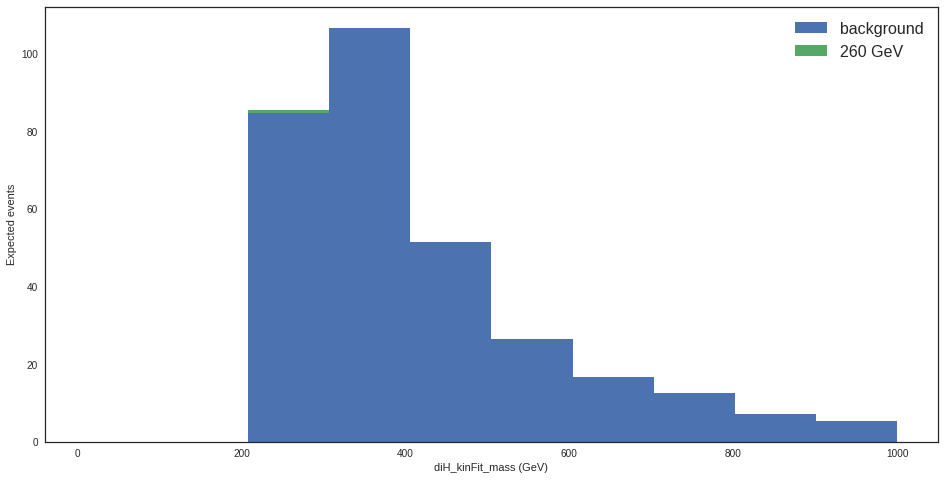

In [22]:
show = True
nBins = 10


weightsCut = [weightCutBackground] + [weightCutSignal[i]/weightCutRatio[i] for i in range(len(weightSignal))]
weights = [weightBackground] + [weightSignal[i]/weightRatio[i] for i in range(len(weightSignal))]

# variables to show
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']
genFeatures = [var for var in allSignalData.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in allSignalData.columns if var not in genFeatures] #Reconstructed features; ok for training
pTEtaPhi = [var for var in trainFeatures for x in ['eta', 'phi', 't_1_mass'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]

toAnalise = ['diH_mass', 'diH_kinFit_mass']
#['h_tt_mass', 'h_tt_svFit_mass'] #['diH_mass', 'diH_kinFit_mass']
# fsFeatures + ['sT', 'hT', 'mT'] # ['sT', 'hT', 'mT', 'h_bb_mass', 'h_tt_mass', 'diH_mass']
#['h_bb_eta', 'h_bb_mass', 'h_bb_pT', 'h_tt_eta', 'h_tt_mass', 'h_tt_pT', 'diH_mass', 'diH_pT', 'diH_eta']

fig = plt.figure(figsize=(16, 8*len(toAnalise)))

dataLimits = {'sT': (0, 800),
              'hT': (0, 600),
              'mT': (0, 250),
              't_0_pT': (0, 150),
              't_0_mass': (0, 2),
              't_1_pT': (15, 200),
              'b_0_pT': (15, 300),
              'b_0_mass': (0, 35),
              'b_0_csv': (0, 1),
              'b_1_pT': (0, 100),
              'b_1_mass': (0, 40),
              'b_1_csv': (0, 1),
              'mPT_pT': (0, 500),
              'h_tt_pT': (0, 300),
              'h_tt_mass': (0, 300),
              'h_bb_pT': (0, 150),
              'h_bb_mass': (0, 200),
              'diH_pT': (0, 220),
              'diH_mass': (0, 1000),
              'diH_kinFit_mass': (10, 1000),
              'h_tt_svFit_mass': (10, 300)
             }
if show:
    for i, varToAnalise in enumerate(toAnalise):

        if varToAnalise in dataLimits:
            bins = np.linspace(dataLimits[varToAnalise][0], dataLimits[varToAnalise][1], nBins+1)
        else:
            bins = np.linspace(min(allBackgroundData[varToAnalise]), max(allBackgroundData[varToAnalise]), nBins+1)

        fig.add_subplot(len(toAnalise),2,2*i+1)

        if combineSignal:
            labels = ["background", "signal"]
            histCutData = [allCutBackgroundAnal[varToAnalise], allCutSignalAnal[varToAnalise]]
            histData = [allBackgroundAnal[varToAnalise], allSignalAnal[varToAnalise]]
        else:
            labels = ["background"] + [str(energies[i]) + ' GeV' for i in signalIdx]
            histCutData = [allCutBackgroundAnal[varToAnalise]] + [cutSignalAnal[i][varToAnalise] for i in range(len(signalIdx))]
            histData = [allBackgroundAnal[varToAnalise]] + [signalAnal[i][varToAnalise] for i in range(len(signalIdx))]

        plt.hist(histCutData, bins=bins, stacked=True, label=labels, weights=weightsCut)
        plt.xlabel(varToAnalise + ' (GeV)')
        plt.ylabel('Expected events')
        plt.legend(fontsize=16)

        fig.add_subplot(len(toAnalise),2,2*i+2)


        plt.hist(histData, bins=bins, stacked=True, label=labels, weights=weights)
        plt.xlabel(varToAnalise + ' (GeV)')
        plt.ylabel('Expected events')
        plt.legend(fontsize=16)

    plt.show()
    
    fig.savefig("test.pdf", bbox_inches='tight')

## Fitting data (to help with cuts)

### Define functions

In [11]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

def crystallball(x, norm, alpha, n, sigma, mean):
    z = (x - mean)/sigma
    if alpha < 0: z = -z
    C = n/abs(alpha)
    D = sqrt(pi/2)*(1+erf(abs(alpha)/sqrt(2)))
    N = 1/(sigma*(C+D))
    
    selector = (z > -abs(alpha))
    
    sol = np.empty(len(x))
    
    sol[selector] = exp(-.5 * z**2)[selector]
    
    nDivAlpha = n/abs(alpha)
    AA = exp(-.5*alpha**2)
    B = nDivAlpha - abs(alpha)
    arg = nDivAlpha/(B-z)
    sol[np.logical_not(selector)] = (AA * power(arg[np.logical_not(selector)],n))
    
    return sol*norm

### Fit h_tt_mass

In [12]:
fig = plt.figure(figsize=(16,16))

fitResults_h_tt_mass = []

for i in range(len(signalData)):
    y, x = np.histogram(signalData[i]['h_tt_mass'], bins=100)

    xCenter = 1/2 * (x[1:] + x[:-1])

    select = (y != 0)
    
    popt,pcov = curve_fit(crystallball, xCenter[select], y[select], p0=[120,-1,10,30,110], sigma=sqrt(y[select])
                          , bounds=[[0,-10,.5,0,80],[1000,0,100,100,130]])
    
    fig.add_subplot((len(signalData)+1)//2,2,i+1)
    
    plt.plot(xCenter, crystallball(xCenter, *popt))
    plt.hist(signalData[i]['h_tt_mass'], bins=x)
    
    plt.title(str(energies[i]) + " GeV")
    
    fitResults_h_tt_mass.append(popt)

TypeError: only length-1 arrays can be converted to Python scalars

### Fit h_bb_mass

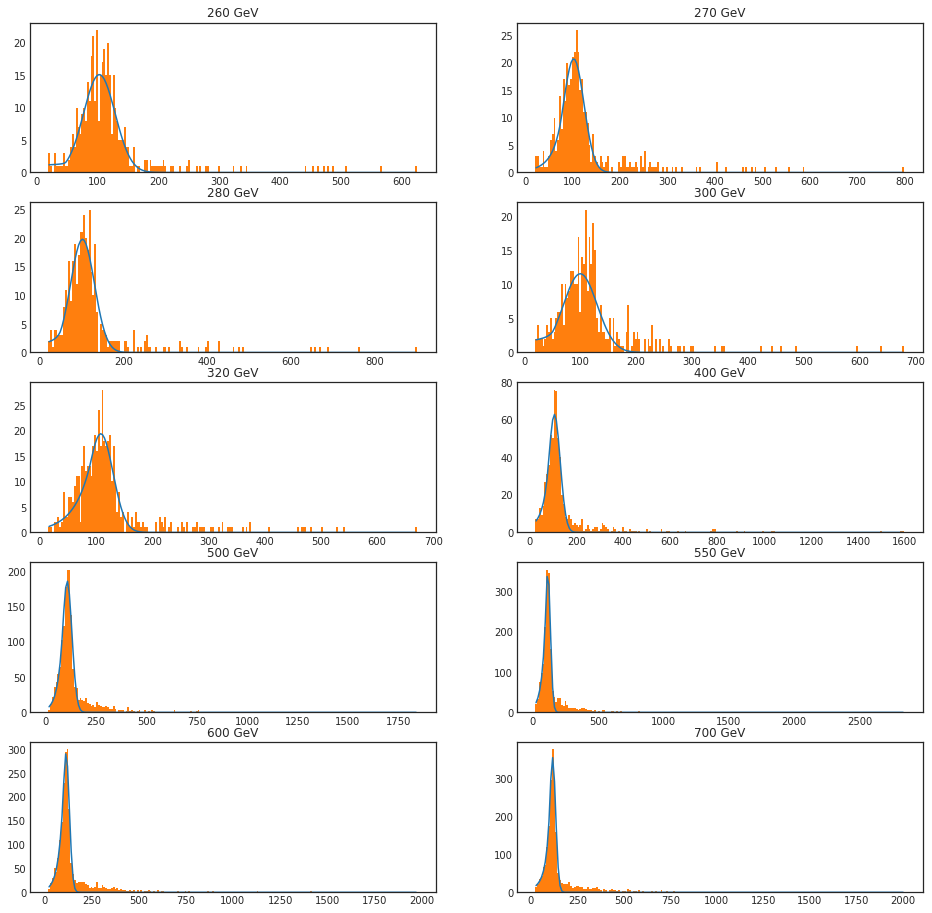

In [12]:
fig = plt.figure(figsize=(16,16))

fitResults_h_bb_mass = []

for i in range(len(signalData)):
    y, x = np.histogram(signalData[i]['h_bb_mass'], bins=200)

    xCenter = 1/2 * (x[1:] + x[:-1])

    select = (y != 0)

    popt,pcov = curve_fit(crystallball, xCenter[select], y[select], p0=[120,1,10,30,110], sigma=sqrt(y[select])
                          , bounds=[[0,-10,.1,0,80],[1000,10,40,100,130]])
    
    fig.add_subplot((len(signalData)+1)//2,2,i+1)
    
    plt.plot(xCenter, crystallball(xCenter, *popt))
    plt.hist(signalData[i]['h_bb_mass'], bins=x)

    plt.title(str(energies[i]) + " GeV")
    
    fitResults_h_bb_mass.append(popt)

### Fit diH_mass

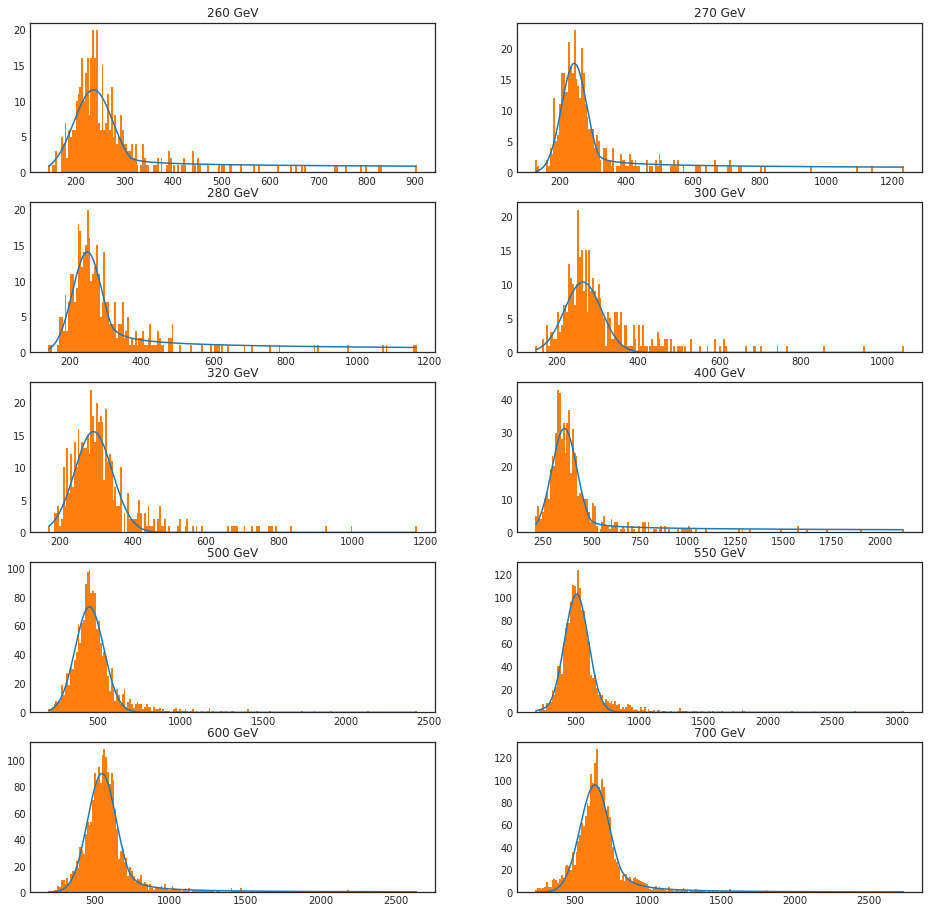

In [13]:
fig = plt.figure(figsize=(16,16))

fitResults_diH_mass = []

for i in range(len(signalData)):
    y, x = np.histogram(signalData[i]['diH_mass'], bins=200)

    xCenter = 1/2 * (x[1:] + x[:-1])

    select = (y != 0)
    
    try:
        popt,pcov = curve_fit(crystallball, xCenter[select], y[select], p0=[10,3,10,40,energies[i]], sigma=sqrt(y[select])
                              , bounds=[[0,-10,.1,0,energies[i]/1.2],[1000,10,20,100,energies[i]*1.2]])
    except RuntimeError:
        print("failure for energy " + str(energies[i]) + " GeV")
    
    fig.add_subplot((len(signalData)+1)//2,2,i+1)
    
    plt.plot(xCenter, crystallball(xCenter, *popt))
    plt.hist(signalData[i]['diH_mass'], bins=x)

    plt.title(str(energies[i]) + " GeV")
    
    fitResults_diH_mass.append(popt)

#### Fit results

In [14]:
fitResults_diH_mass = np.array(fitResults_diH_mass)
print(fitResults_diH_mass[:,4]/energies , np.average(fitResults_diH_mass[:,4]/energies))

[ 0.91048584  0.90111199  0.8929299   0.88112232  0.91053744  0.90236651
  0.90415815  0.91996979  0.91487321  0.91439955] 0.905195469005


In [15]:
print(np.average(fitResults_h_tt_mass, axis=0))
print(np.average(fitResults_h_bb_mass, axis=0))

[  54.30536896   -0.8204799    36.53408048   21.64300541  110.97263886]
[ 132.97700264    1.16421499   14.74782973   22.93787221  107.77250776]


In [16]:
print(np.array(fitResults_h_tt_mass)[:,3:5])
print(np.array(fitResults_h_bb_mass)[:,3:5])

[[  20.29320122  113.77716757]
 [  24.20538302  113.65766683]
 [  21.74345234  113.56940521]
 [  18.05746638  107.59554713]
 [  24.28371573  114.82932166]
 [  21.9374941   111.23260081]
 [  22.008236    110.54951436]
 [  21.65022984  110.30641493]
 [  21.15696936  107.55437708]
 [  21.09390615  106.65437301]]
[[  25.82035702  102.8192349 ]
 [  21.56535591  102.58817445]
 [  28.551088    102.34975889]
 [  30.08680966  100.3593104 ]
 [  21.70683089  108.5903732 ]
 [  24.53614084  107.31084315]
 [  23.36432329  107.94418031]
 [  19.89747369  114.43681173]
 [  17.50478114  115.01565324]
 [  16.34556162  116.31073732]]


In [17]:
sigmas = 1.7
h_tt_mass_avg = np.average(np.array(fitResults_h_tt_mass)[:,4])
h_tt_mass_std = np.average(np.array(fitResults_h_tt_mass)[:,3])*sigmas
h_bb_mass_avg = np.average(np.array(fitResults_h_bb_mass)[:,4])
h_bb_mass_std = np.average(np.array(fitResults_h_bb_mass)[:,3])*sigmas


h_tt_mass_avg = 103
h_tt_mass_std = 49
h_bb_mass_avg = 105
h_bb_mass_std = 35

#h_tt_mass_avg = 111
#h_tt_mass_std = 45
#h_bb_mass_avg = 116
#h_bb_mass_std = 35


print("h_tt_mass: {}+-{}".format(h_tt_mass_avg, h_tt_mass_std))
print("h_bb_mass: {}+-{}".format(h_bb_mass_avg, h_bb_mass_std))

h_tt_mass: 103+-49
h_bb_mass: 105+-35


#### acepptance as a function of sigmas of h_bb_mass and h_tt_mass

In [18]:
def acceptanceHiggsMass(variable, limits):
    x = np.linspace(limits[0], limits[1],100)
    y = []
    for j in x:
        newSignalSelector = [pandas.Series(np.ones(len(signal_anal), dtype=bool)) for signal_anal in signalAnal]
        newBackgroundSelector = [pandas.Series(np.ones(len(background_anal), dtype=bool)) for background_anal in backgroundAnal]
        for newSelector, selector, analData in [(newSignalSelector, signalSelector, signalAnal), (newBackgroundSelector, backgroundSelector, backgroundAnal)]:
            for i in range(len(selector)):
                if variable == 'sigmas':
                    newSelector[i] = selector[i] & (((analData[i]['h_bb_mass']-h_bb_mass_avg)/(h_bb_mass_std*j))**2 + ((analData[i]['h_tt_mass']-h_tt_mass_avg)/(h_tt_mass_std*j))**2 < 1)
                elif variable == 'h_bb_mass_avg':
                    newSelector[i] = selector[i] & (((analData[i]['h_bb_mass']-j)/(h_bb_mass_std))**2 + ((analData[i]['h_tt_mass']-h_tt_mass_avg)/(h_tt_mass_std))**2 < 1)
                elif variable == 'h_bb_mass_std':
                    newSelector[i] = selector[i] & (((analData[i]['h_bb_mass']-h_bb_mass_avg)/(j))**2 + ((analData[i]['h_tt_mass']-h_tt_mass_avg)/(h_tt_mass_std))**2 < 1)
                elif variable == 'h_tt_mass_avg':
                    newSelector[i] = selector[i] & (((analData[i]['h_bb_mass']-h_bb_mass_avg)/(h_bb_mass_std))**2 + ((analData[i]['h_tt_mass']-j)/(h_tt_mass_std))**2 < 1)
                elif variable == 'h_tt_mass_std':
                    newSelector[i] = selector[i] & (((analData[i]['h_bb_mass']-h_bb_mass_avg)/(h_bb_mass_std))**2 + ((analData[i]['h_tt_mass']-h_tt_mass_avg)/(j))**2 < 1)

        newCutSignalAnal, newCutBackgroundAnal = [], []

        for i in range(len(signalAnal)):
            newCutSignalAnal.append(signalAnal[i][newSignalSelector[i]])

        for i in range(len(backgroundAnal)):
            newCutBackgroundAnal.append(backgroundAnal[i][newBackgroundSelector[i]])
        y.append(calculateFOM(newCutSignalAnal, newCutBackgroundAnal, signalIdx, backgroundIdx))

    plt.plot(x,y)
    
    max_y = max(y)
    
    p0 = [(limits[0]+limits[1])/2, max_y, -0.001, -0.001]
    bounds = [[limits[0], max_y/1.5, -50, -50],[limits[1], max_y*1.5, 0, 50]]

    popt,pcov = curve_fit(taylorExpand, x, y, p0=p0, bounds=bounds)

    print(popt)

    plt.plot(x, taylorExpand(x, *popt))

#### sigmas

[ 0.99271431  0.68860932 -0.34751728  0.43209611]


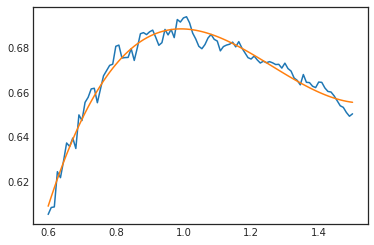

In [19]:
acceptanceHiggsMass('sigmas', limits=[0.6,1.5])

#### h_tt_mass_avg

[  1.07833686e+02   6.90440433e-01  -1.12109548e-04  -1.84330349e-06]


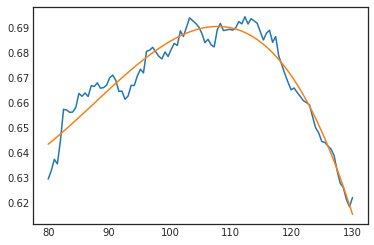

In [20]:
acceptanceHiggsMass('h_tt_mass_avg', limits=[80,130])

#### h_bb_mass_avg

[  1.09677593e+02   6.93912712e-01  -1.84387661e-04   6.57551490e-07]


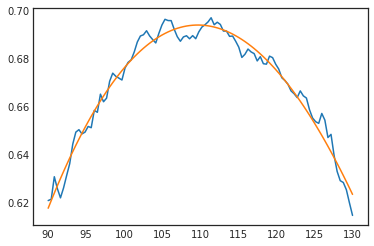

In [21]:
acceptanceHiggsMass('h_bb_mass_avg', limits=[90,130])

#### h_bb_mass_std

[  3.39309175e+01   6.92527509e-01  -1.88858525e-04   1.06558867e-05]


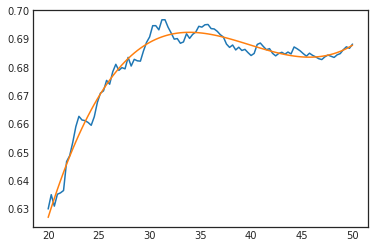

In [22]:
acceptanceHiggsMass('h_bb_mass_std', limits=[20, 50])

#### h_tt_mass_std

[  5.23314459e+01   6.90183192e-01  -6.08261451e-05   8.89266062e-07]


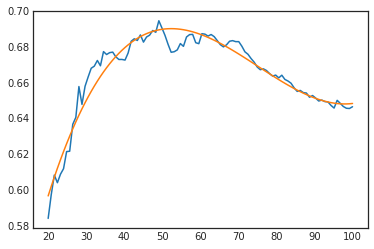

In [23]:
acceptanceHiggsMass('h_tt_mass_std', limits=[20, 100])

In [24]:
allSignalData.columns

Index(['t_0_pT', 't_0_eta', 't_0_phi', 't_0_mass', 't_1_pT', 't_1_eta',
       't_1_phi', 't_1_mass', 'b_0_pT', 'b_0_eta', 'b_0_phi', 'b_0_mass',
       'b_0_csv', 'b_1_pT', 'b_1_eta', 'b_1_phi', 'b_1_mass', 'b_1_csv',
       'mPT_pT', 'mPT_phi', 'h_tt_pT', 'h_tt_eta', 'h_tt_phi', 'h_tt_mass',
       'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_eta', 'h_bb_phi', 'h_bb_mass',
       'diH_pT', 'diH_eta', 'diH_phi', 'diH_mass', 'diH_kinFit_mass',
       'diH_kinFit_prob', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity',
       'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape',
       'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2',
       'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2',
       'gen_t_0_pT', 'gen_t_0_eta', 'gen_t_0_phi', 'gen_t_0_E', 'gen_t_1_pT',
       'gen_t_1_eta', 'gen_t_1_phi', 'gen_t_1_E', 'gen_b_0_pT', 'gen_b_0_eta',
       'gen_b_0_phi', 'gen_b_0_E', 'gen_b_1_pT', 'gen_b_1_eta', 'gen_b_1_phi',
       'gen_b_1_E', 'gen_diH_pT', 'gen_di

In [25]:
from bayes_opt import BayesianOptimization

def acceptanceHiggsParms(h_bb_mass_avg, h_bb_mass_std, h_tt_mass_avg, h_tt_mass_std):
    newSignalSelector = [pandas.Series(np.ones(len(signal_anal), dtype=bool)) for signal_anal in signalAnal]
    newBackgroundSelector = [pandas.Series(np.ones(len(background_anal), dtype=bool)) for background_anal in backgroundAnal]
    for newSelector, selector, analData in [(newSignalSelector, signalSelector, signalAnal), (newBackgroundSelector, backgroundSelector, backgroundAnal)]:
        for i in range(len(selector)):
            newSelector[i] = selector[i] & (((analData[i]['h_bb_mass']-h_bb_mass_avg)/(h_bb_mass_std))**2 + ((analData[i]['h_tt_mass']-h_tt_mass_avg)/(h_tt_mass_std))**2 < 1)
    newCutSignalAnal, newCutBackgroundAnal = [], []

    for i in range(len(signalAnal)):
        newCutSignalAnal.append(signalAnal[i][newSignalSelector[i]])

    for i in range(len(backgroundAnal)):
        newCutBackgroundAnal.append(backgroundAnal[i][newBackgroundSelector[i]])
    return calculateFOM(newCutSignalAnal, newCutBackgroundAnal, signalIdx, backgroundIdx)

bo = BayesianOptimization(acceptanceHiggsParms,
                          {'h_bb_mass_avg': (100, 120), 'h_bb_mass_std': (30, 40),
                           'h_tt_mass_avg': (95, 115), 'h_tt_mass_std': (40, 55)})

bo.explore({'h_bb_mass_avg': [105, 116], 'h_bb_mass_std': [35, 35],
            'h_tt_mass_avg': [103 , 111], 'h_tt_mass_std': [49, 45]})

#bo.initialize(
#        {'target': [0.5, 1],
#         'h_bb_mass_avg': [100, 120], 'h_bb_mass_std': [30, 40],
#         'h_tt_mass_avg': [95 , 115], 'h_tt_mass_std': [40, 55]}
#)

bo.maximize(init_points=20, n_iter=15, kappa=2)

print(bo.res['max'])

Initialization
-----------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   h_bb_mass_avg |   h_bb_mass_std |   h_tt_mass_avg |   h_tt_mass_std | 
    1 | 00m00s |    0.69355 |        105.0000 |         35.0000 |        103.0000 |         49.0000 | 
    2 | 00m00s |    0.68242 |        116.0000 |         35.0000 |        111.0000 |         45.0000 | 
    3 | 00m00s |    0.68935 |        114.5214 |         35.0469 |         98.2958 |         51.1600 | 
    4 | 00m00s |    0.68137 |        113.0881 |         32.3649 |        102.1572 |         43.8480 | 
    5 | 00m00s |    0.68413 |        108.0007 |         33.0585 |         99.5101 |         45.9347 | 
    6 | 00m00s |    0.67030 |        106.3387 |         32.1291 |         97.7225 |         43.6036 | 
    7 | 00m00s |    0.66492 |        105.9080 |         32.0084 |        112.8587 |         42.6294 | 
    8 | 00m00s |    0.67829 |        102.9957 |         33.

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'funcalls': 52, 'warnflag': 2, 'grad': array([  3.29806844e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 6, 'funcalls': 54, 'warnflag': 2, 'grad': array([ -5.55357474e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   23 | 00m32s |    0.65553 |        120.0000 |         40.0000 |        115.0000 |         55.0000 | 
   24 | 00m13s |    0.65207 |        119.9218 |         39.9671 |         96.7835 |         41.2293 | 
   25 | 00m15s |    0.67833 |        119.5930 |         39.9116 |         95.4182 |         54.9042 | 
   26 | 00m20s |    0.68206 |        103.7127 |         40.0000 |        115.0000 |         55.0000 | 


KeyboardInterrupt: 